In [1]:
import burnman
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy import constants
from burnman import minerals, Composite,Composition, Layer, Planet, Mineral
from burnman.tools.chemistry import formula_mass
from scipy.optimize import bisect

Constantes

In [3]:
G = constants.G.value
R_gas = constants.R.value
GPa = 1e9 #Pa
km = 1000 #m
den = 1000/100**3 #g/cm^-3
deg = 180/np.pi
rad = 1/deg

#Tierra
Me = constants.M_earth.value
Re = constants.R_earth.value
surface_T = 300 #K
CMF = 0.325 #Core Mass Fraction

Funciones

In [4]:
def build_planet(name, core_radius, R_target,
                                inner_core_mat, outer_core_mat,
                                lower_mantle_mat, upper_mantle_mat,
                                n_inner=20, n_outer=40, n_lower=60, n_upper=40):
    """
    Crea un planeta para un radio de núcleo dado.
    Devuelve (planet, M_model) donde M_model está en kg.
    """
    # Inner / outer core
    r_inner = np.linspace(0.0, 0.2*core_radius, n_inner)
    r_outer = np.linspace(0.2*core_radius, core_radius, n_outer)

    dUm = 660*km * R_target/Re

    r_lower = np.linspace(core_radius, core_radius + dUm, n_lower)
    r_upper = np.linspace(core_radius + dUm, R_target, n_upper)

    # Inner core
    layer_inner = Layer('inner_core', radii=r_inner)
    layer_inner.set_material(inner_core_mat)
    layer_inner.set_temperature_mode('adiabatic')

    # Outer core
    layer_outer = Layer('outer_core', radii=r_outer)
    layer_outer.set_material(outer_core_mat)
    layer_outer.set_temperature_mode('adiabatic')

    # Lower mantle
    layer_lower = Layer('lower_mantle', radii=r_lower)
    layer_lower.set_material(lower_mantle_mat)
    layer_lower.set_temperature_mode('adiabatic')

    # Upper mantle
    layer_upper = Layer('upper_mantle', radii=r_upper)
    layer_upper.set_material(upper_mantle_mat)
    layer_upper.set_temperature_mode('adiabatic', temperature_top=surface_T)

    # Construir planeta
    planet = Planet(f'{name}', [layer_inner, layer_outer, layer_lower, layer_upper])
    try:
        planet.make(radius=R_target)
    except TypeError:
        planet.make()

    # Masa total
    if hasattr(planet, 'mass'):
        M_model = planet.mass
    else:
        M_model = planet.enclosed_mass[-1]

    return planet, M_model


def find_core_radius_bisect(name, M_target, R_target,
                            inner_core_mat, outer_core_mat,
                            lower_mantle_mat, upper_mantle_mat):
    """
    Usa SciPy bisect para encontrar el core_radius que da la masa objetivo.
    """
    def mass_error(core_radius):
        _, M_model = build_planet(name, core_radius, R_target,
                                                  inner_core_mat, outer_core_mat,
                                                  lower_mantle_mat, upper_mantle_mat)
        return M_model - M_target

    # Buscar entre 0.1 Rp y 0.7 Rp
    best_core_r = bisect(mass_error, 0.1*R_target, 0.7*R_target, xtol=1e3)
    planet_best, M_best = build_planet(name, best_core_r, R_target,
                                                       inner_core_mat, outer_core_mat,
                                                       lower_mantle_mat, upper_mantle_mat,
                                                       n_inner=50, n_outer=100,
                                                       n_lower=200, n_upper=100)
    return planet_best, best_core_r, M_best


def Planet_Perfiles(planet):
    rho = planet.density
    P = planet.pressure
    g = planet.gravity
    T = planet.temperature
    m = planet.mass
    r = planet.radii

    plt.figure(figsize=(12,4))
    plt.subplot(1,4,1)
    plt.plot(r/km, P/GPa)
    plt.ylabel('P (GPa)'); plt.xlabel('Depth (km)'); plt.title('P(z)')

    plt.subplot(1,4,2)
    plt.plot(r/km, rho)
    plt.ylabel('rho (kg/m3)');plt.xlabel('Depth (km)'); plt.title('rho(z)')

    plt.subplot(1,4,3)
    plt.plot(r/km, g)
    plt.ylabel('g (m/s2)');plt.xlabel('Depth (km)'); plt.title('g(z)')

    plt.subplot(1,4,4)
    plt.plot(r/km, T)
    plt.ylabel('T (K)');plt.xlabel('Depth (km)'); plt.title('T(z)')

    plt.tight_layout()
    plt.show()

Parametros

In [27]:
#TRAPPIST-1e
Mp = 0.692 * Me
Rp = 0.92 * Re

#Nucleo
R_core = 0.55 * Rp
M_core = CMF * Mp
M_inner_core = 0.05 * M_core
M_outer_core = 0.95 * M_core

radii_inner = np.linspace(0., R_core*0.2, 50)
radii_outer = np.linspace(R_core*0.2, R_core, 100)

#Manto
dUm = 660*km * Rp/Re

M_mantle = Mp - M_core
M_upper_mantle = 0.17 * Mp
M_lower_mantle = M_mantle - M_upper_mantle

radii_lower = np.linspace(R_core, Rp - dUm, 100)
radii_upper = np.linspace(Rp - dUm, Rp, 50)


Compisicion de las Capas del Planeta

In [ ]:
inner_core_composition = Composition({'Fe': 93.3, 'Ni': 5., 'S': 0.5, 'Si':1. ,'O': 0.2}, 'weight')
outer_core_composition = Composition({'Fe': 86., 'Ni': 5., 'S': 2., 'Si': 5., 'O': 2.}, 'weight')

inner_core_composition = Composition({'Fe': 94.4, 'Ni': 5., 'Si': 0.55, 'O': 0.05}, 'weight')
outer_core_composition = Composition({'Fe': 90., 'Ni': 5., 'Si': 2., 'O': 3.}, 'weight')

inner_core_composition = Composition({'Fe': 84.43, 'S': 8.02, 'Ni' : 6.92, 'O': 0.11}, 'weight')
outer_core_composition = Composition({'Fe': 79.15, 'S': 8.84, 'Ni' : 6.49, 'O': 5.34}, 'weight')

In [23]:
#Nucleo


inner_core_composition = Composition({'Fe': 94.4, 'Ni': 5., 'Si': 0.55, 'O': 0.05}, 'weight')
outer_core_composition = Composition({'Fe': 90., 'Ni': 5., 'Si': 2., 'O': 3.}, 'weight')

for c in [inner_core_composition, outer_core_composition]:
    c.renormalize('atomic', 'total', 1.)

inner_core_elemental_composition = dict(inner_core_composition.atomic_composition)
outer_core_elemental_composition = dict(outer_core_composition.atomic_composition)
inner_core_molar_mass = formula_mass(inner_core_elemental_composition)
outer_core_molar_mass = formula_mass(outer_core_elemental_composition)

hcp_iron = minerals.SE_2015.hcp_iron()
params_in = hcp_iron.params

params_in['name'] = 'modified solid iron'
params_in['formula'] = inner_core_elemental_composition
params_in['molar_mass'] = inner_core_molar_mass
inner_core_comp = Mineral(params=params_in)

liq_iron  = minerals.SE_2015.liquid_iron()
params_oc = liq_iron.params
params_oc['name'] = 'modified solid iron'
params_oc['formula'] = outer_core_elemental_composition
params_oc['molar_mass'] = outer_core_molar_mass
outer_core_comp = Mineral(params=params_oc)

#Manto Superior
olivine = minerals.SLB_2024.olivine(molar_fractions=[0.92, 0.08])
enstatite = minerals.SLB_2011.enstatite()
dioside = minerals.SLB_2024.diopside()
upper_mantle_comp = Composite([olivine, enstatite, dioside], [0.7, 0.15, 0.15])

#Manto Inferior
Bridgmanite = minerals.SLB_2011.mg_perovskite()
ferropericlase = minerals.SLB_2011.ferropericlase(molar_fractions=[0.8, 0.2])
Ca_perovskite = minerals.SLB_2011.ca_perovskite()
lower_mantle_comp = Composite([Bridgmanite, ferropericlase, Ca_perovskite], [0.80, 0.15, 0.05])

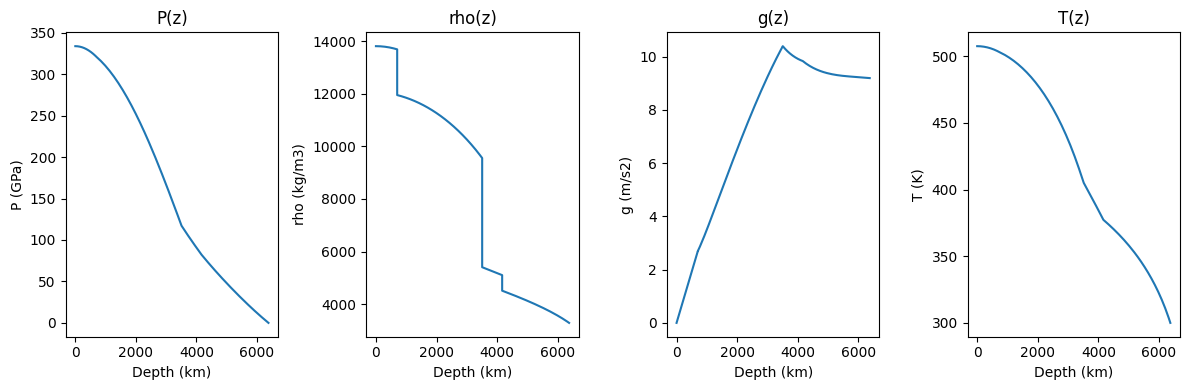

Masa Tierra: 0.9380 Me


In [ ]:
Tierra, M_Tierra = build_planet('Tierra', 0.55*Re, Re,
                                inner_core_comp, outer_core_comp,
                                lower_mantle_comp, upper_mantle_comp)

Planet_Perfiles(Tierra)
print(f'Masa Tierra: {M_Tierra/Me:.4f} Me')

In [28]:
Trappist1e, M_trappist1e = build_planet('TRAPPIST-1e', R_core, Rp,
                                       inner_core_comp, outer_core_comp,
                                       lower_mantle_comp, upper_mantle_comp)

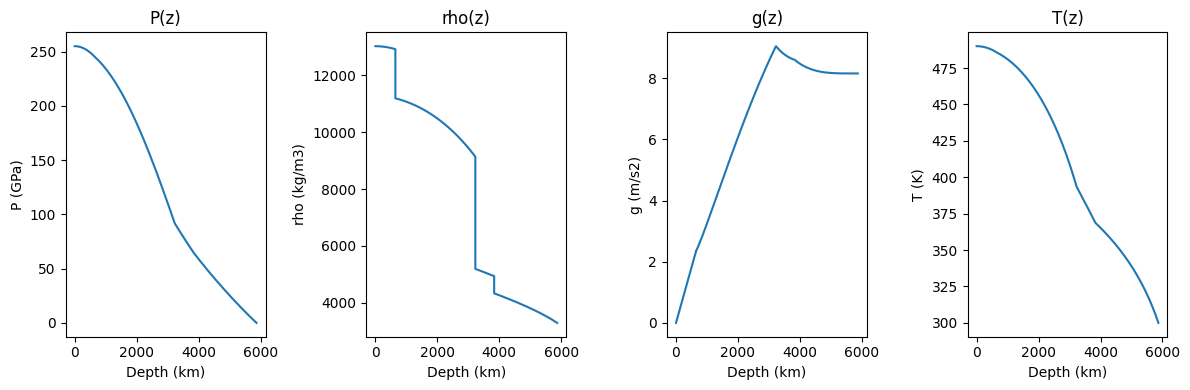

Masa del Planeta (Me): 0.705


In [30]:
Planet_Perfiles(Trappist1e)
print(f'Masa del Planeta (Me): {M_trappist1e/Me:.3f}')

In [31]:
planet_best, best_core_r, M_best = find_core_radius_bisect('TRAPPIST-1e', 
                                                           Mp, Rp,
                                        inner_core_comp, outer_core_comp,
                                       lower_mantle_comp, upper_mantle_comp)
print("Core radius (km):", best_core_r/1e3)
print("Final Mass (Me):", M_best/Me)

Core radius (km): 3142.223285351563
Final Mass (Me): 0.6919413870866075


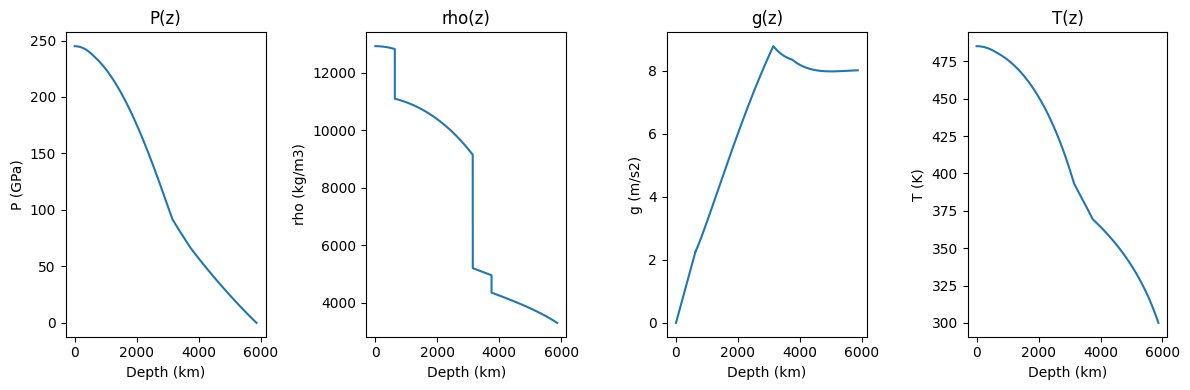

Masa del Planeta (Me): 0.692


In [32]:
Planet_Perfiles(planet_best)
print(f'Masa del Planeta (Me): {M_best/Me:.3f}')